<a href="https://colab.research.google.com/github/farz-1/template/blob/master/CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/colab/

/content/drive/MyDrive/colab


In [3]:
import json

with open('tad_data.json') as f:
    document = json.load(f)


In [4]:
!head tad_data.json

[
  {
    "UID": "AVqkIhwDv8e3D1O-lebb",
    "Name": "All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",
    "DoRecommend": "TRUE",
    "Rating": 5,
    "Review": "This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.",
    "Title": "Kindle",
    "Username": "Adapter"
  },


In [5]:
document[0]['Review']

'This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.'

In [6]:
def column(matrix, i):
    return [row[i] for row in matrix]
import random

data=random.choices(document,k=9900)

In [7]:

data[0]

vals=[]
vals.clear()


for i in range(len(data)):
    if(data[i]['DoRecommend']!="TRUE" and data[i]['DoRecommend']!="FALSE"):
        vals.append(i)
    if(len(data[i]['Review'])<5):
        vals.append(i)

print(len(data))

vals=sorted(vals,reverse=True)

print(len(data))
for g in vals:
  del data[g]
print(len(vals))
print(len(data))
print(type(data[0]['DoRecommend']))




9900
9900
198
9702
<class 'str'>


In [8]:
from sklearn.model_selection import train_test_split

X= column(data,'DoRecommend')
Y= column(data,'Review')

rec_train_val,rec_test,rev_train_val,rev_test=train_test_split(X,Y,test_size=0.2, random_state=12)
rec_train,rec_val,rev_train,rev_val=train_test_split(rec_train_val,rev_train_val,test_size=0.25,random_state=12)
print(len(rec_train))
print(len(rec_val))
print(len(rec_test))

total=len(data)

5820
1941
1941


In [9]:
len(rev_train)/total, len(rev_val)/total, len(rev_test)/total

(0.5998763141620285, 0.20006184291898577, 0.20006184291898577)

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
print(f"{len(rec_train)=}\t{len(rev_train)=}")
print(f"{len(rec_val)=}\t{len(rev_val)=}")
print(f"{len(rec_test)=}\t{len(rev_test)=}")

len(rec_train)=5844	len(rev_train)=5844
len(rec_val)=1948	len(rev_val)=1948
len(rec_test)=1949	len(rev_test)=1949


In [22]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import random
# Step 0: Vectorizing the text
vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf = vectorizer.fit_transform(rev_train)

# Step 1: Picking k random centroids
k = 5 # number of clusters
samples, features = tfidf.shape
centroids = np.zeros((k, features))
for i in range(k):
    centroid = tfidf[np.random.choice(samples)].toarray()
    centroids[i] = centroid

# Step 2: Assigning each vector to its closest centroid
def assign_cluster(tfidf, centroids):
    clusters = []
    for i in range(tfidf.shape[0]):
        vector = tfidf[i].toarray()
        distances = np.linalg.norm(vector - centroids, axis=1)
        closest_centroid = np.argmin(distances)
        clusters.append(closest_centroid)
    return clusters

clusters = assign_cluster(tfidf, centroids)

# Step 3: Recalculate the centroids based on the closest vectors
def recalculate_centroids(tfidf, cluster_assignment, k):
    new_centroids = np.zeros((k, features))
    for i in range(k):
        cluster_mean = np.mean(tfidf[np.where(np.array(clusters) == i)].toarray(), axis=0)
        new_centroids[i] = cluster_mean
    return new_centroids

max_iterations = 100
for iteration in range(max_iterations):
    clusters = assign_cluster(tfidf, centroids)
    new_centroids = recalculate_centroids(tfidf, clusters, k)
    if np.allclose(centroids, new_centroids):
        break
    centroids = new_centroids

print("Converged after", iteration + 1, "iterations.")



Converged after 56 iterations.


In [23]:
# Step 4: Get the documents assigned to each cluster and the top 5 tokens with the highest magnitude in the corresponding centroid
cluster_assignments = assign_cluster(tfidf, centroids)

for i in range(k):
    print(f"Cluster {i+1}:")
    documents_in_cluster = [rev_train[j] for j in range(len(rev_train)) if cluster_assignments[j] == i]
    print(f"Number of documents in cluster: {len(documents_in_cluster)}")
    centroid = centroids[i]
    sorted_idx = np.argsort(centroid)[::-1][:5] # Get the indices of the top 5 tokens with the highest magnitude
    top_tokens = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(idx)] for idx in sorted_idx]
    print(f"Top 5 tokens in centroid: {top_tokens}")
    print("Example documents in cluster:")
    for j in range(min(5, len(documents_in_cluster))):
        print(f"Document {j+1}: {documents_in_cluster[j]}")
    print("----")


Cluster 1:
Number of documents in cluster: 2819
Top 5 tokens in centroid: ['kindle', 'love', 'bought', 'fire', 'one']
Example documents in cluster:
Document 1: Many of our questions to her she miss interpreted or replied as not understanding what we were looking for. Distance for her to hear us was minimal. I returned this one and purchased the "Google" and this one is much better and more knowledgeable with answers. Both devices recommend using the phone app and also making other purchases for more usage of items that may be available. I didn't expect additional charges and so I'm not to thrilled with either one but I did keep the Google device in hopes of better to come in the future.
Document 2: Hard to figure out to use this tablet can't figure out how to close apps. Also says no storage to run wifi. Lastly bought three of them and one is not working wish it came with a user guide
Document 3: Comes with a bunch of apps to watch TV and to play games as well.
Document 4: We originall

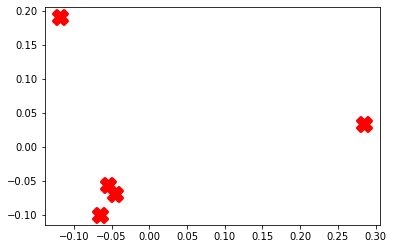

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(centroids)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], marker='X', s=200, linewidths=3, color='r')
plt.show()

In [26]:
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# Print the sizes of each set
print("Number of training examples:", len(train_data))
print("Number of validation examples:", len(val_data))
print("Number of test examples:", len(test_data))

Number of training examples: 5844
Number of validation examples: 1948
Number of test examples: 1949


In [27]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import random

rec_train_val, rec_test, rev_train_val, rev_test = train_test_split(
    [d['DoRecommend'] + ' ' + d['Review'] for d in data],
    [d['Review'] for d in data],
    test_size=0.2, random_state=12)
rec_train, rec_val, rev_train, rev_val = train_test_split(
    rec_train_val, rev_train_val,
    test_size=0.25, random_state=12)

# Vectorize the text
vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf = vectorizer.fit_transform(rev_train_val)

# Define the number of clusters
k = 5

# Initialize the centroids
samples, features = tfidf.shape
centroids = np.zeros((k, features))
for i in range(k):
    centroid = tfidf[np.random.choice(samples)].toarray()
    centroids[i] = centroid

# Define the maximum number of iterations
max_iterations = 100

# Iterate until convergence
for iteration in range(max_iterations):
    # Assign each vector to its closest centroid
    clusters = []
    for i in range(tfidf.shape[0]):
        vector = tfidf[i].toarray()
        distances = np.linalg.norm(vector - centroids, axis=1)
        closest_centroid = np.argmin(distances)
        clusters.append(closest_centroid)

    # Recalculate the centroids based on the closest vectors
    new_centroids = np.zeros((k, features))
    for i in range(k):
        cluster_mean = np.mean(tfidf[np.where(np.array(clusters) == i)].toarray(), axis=0)
        new_centroids[i] = cluster_mean

    # Check for convergence
    if np.allclose(centroids, new_centroids):
        break

    centroids = new_centroids

print("Converged after", iteration + 1, "iterations.")

Converged after 22 iterations.


In [28]:
rec_train_val[0]

'TRUE This is a good product and streams very well for all of our favorite online services!'

In [29]:
# Assign each vector to its closest centroid
clusters = []
for i in range(tfidf.shape[0]):
    vector = tfidf[i].toarray()
    distances = np.linalg.norm(vector - centroids, axis=1)
    closest_centroid = np.argmin(distances)
    clusters.append(closest_centroid)
# Define a function to print the top tokens in each cluster
def print_top_tokens_in_cluster(cluster_idx, centroid, vectorizer, n_tokens=5):
    top_indices = centroid.argsort()[::-1][:n_tokens]
    top_tokens = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(index)] for index in top_indices]
    print("Cluster", cluster_idx)
    print("Top tokens:", top_tokens)
    print()

# Print the first few documents assigned to each cluster and their top tokens
num_docs_to_print = 5
for i in range(k):
    cluster_indices = np.where(np.array(clusters) == i)[0]
    print("Documents assigned to cluster", i+1, ":")
    for j, idx in enumerate(cluster_indices):
        if j >= num_docs_to_print:
            break
        print(rev_train_val[idx])
    print()
    print_top_tokens_in_cluster(i, centroids[i], vectorizer)


Documents assigned to cluster 1 :
Bought two...one for each kid for Christmas. Perfect for the kids. Download their shows and music. Keeps them off ours. Durable enough for them to use on their own.
I have used this everynight since I bought it to catch all my favorite shows and movies. I am so glad I bought this product!!!!!!
Bought this tablet for my 2 &1/2 year old and it is perfect. Games and videos that come on it are very age appropriate and the tablet has been very durable thus far.
We bought this as a birthday present for my 8 year old. It has almost everything she wants on it. Only problem is Amazon's app options are limited compared to Apple or Google Play. Other than that, she loves it.
My children loved their previous kindles so much I bought them an upgrade with the case - so worth it.

Cluster 0
Top tokens: ['loves', 'bought', 'gift', 'old', 'year']

Documents assigned to cluster 2 :
This is a good product and streams very well for all of our favorite online services!
Sou

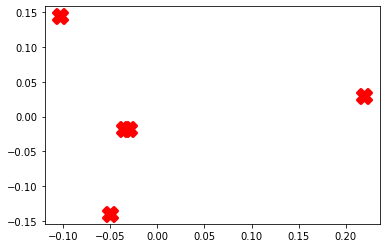

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(centroids)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], marker='X', s=200, linewidths=3, color='r')
plt.show()

In [31]:
from sklearn.dummy import DummyClassifier

# Split the data into train, validation, and test sets
# ...

# Create a dummy classifier with strategy 'most_frequent'
dummy_clf = DummyClassifier(strategy='stratified')

# Fit the classifier on the training data
dummy_clf.fit(rec_train, rev_train)

# Predict on the validation data
y_pred = dummy_clf.predict(rec_val)

# Calculate accuracy on the validation data
accuracy = dummy_clf.score(rec_val, rev_val)

print("Accuracy:", accuracy)


Accuracy: 0.0


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Convert text data to a matrix of word counts
vectorizer = CountVectorizer(stop_words=stop_words)
X_text = vectorizer.fit_transform(rev_train_val)

# Convert the word count matrix to a binary matrix of one-hot vectors
encoder = OneHotEncoder()
X_one_hot = encoder.fit_transform(X_text.toarray())

# Convert the sparse matrix to a dense numpy array
X_one_hot_dense = X_one_hot.toarray()

# Concatenate the one-hot matrix with the binary DoRecommend feature
X = np.concatenate([X_one_hot_dense, np.array(rec_train_val).reshape(-1, 1)], axis=1)

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, rec_train_val, test_size=0.2, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=12)

# Fit the LogisticRegression model to the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model on the validation and testing sets
print("Validation accuracy:", model.score(X_val, y_val))
print("Testing accuracy:", model.score(X_test, y_test))


In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
X_train_val, X_test, y_train_val, y_test = train_test_split(
    [d['DoRecommend'] + ' ' + d['Review'] for d in data],
    [d['DoRecommend'] for d in data],
    test_size=0.2, random_state=12)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25, random_state=12)

dummy_classifiers = [
    DummyClassifier(strategy="most_frequent"),
    DummyClassifier(strategy="stratified")
]
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)
svc = SVC(kernel='rbf')

# Define the feature representations
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Evaluate the classifiers using cross-validation
for clf in dummy_classifiers + [logistic_regression, svc]:
    for vectorizer in [count_vectorizer, tfidf_vectorizer]:
        X_train_transformed = vectorizer.fit_transform(X_train)
        scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
        print(f"{clf.__class__.__name__} with {vectorizer.__class__.__name__}: {scores.mean():.3f} +/- {scores.std():.3f}")
print('*'*50)
# Evaluate the classifiers using cross-validation
results = []
for clf in dummy_classifiers + [logistic_regression, svc]:
    for vectorizer in [count_vectorizer, tfidf_vectorizer]:
        X_train_transformed = vectorizer.fit_transform(X_train)
        X_val_transformed = vectorizer.transform(X_val)
        clf.fit(X_train_transformed, y_train)
        y_pred = clf.predict(X_val_transformed)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='macro',zero_division=0)
        recall = recall_score(y_val, y_pred, average='macro')
        f1 = f1_score(y_val, y_pred, average='macro')
        result = {'Classifier': clf.__class__.__name__,
                  'Vectorizer': vectorizer.__class__.__name__,
                  'Accuracy': accuracy,
                  'Precision': precision,
                  'Recall': recall,
                  'F1': f1}
        results.append(result)

# Print the results
print('{:<25} {:<20} {:<10} {:<10} {:<10} {:<10}'.format(
    'Classifier', 'Vectorizer', 'Accuracy', 'Precision', 'Recall', 'F1'))
best_f1 = 0
for result in results:
    classifier = result['Classifier']
    vectorizer = result['Vectorizer']
    accuracy = result['Accuracy']
    precision = result['Precision']
    recall = result['Recall']
    f1 = result['F1']
    print('{:<25} {:<20} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}'.format(
        classifier, vectorizer, accuracy, precision, recall, f1))
    if f1 > best_f1:
        best_f1 = f1
        best_classifier = classifier
        best_vectorizer = vectorizer



DummyClassifier with CountVectorizer: 0.957 +/- 0.000
DummyClassifier with TfidfVectorizer: 0.957 +/- 0.000
DummyClassifier with CountVectorizer: 0.917 +/- 0.005
DummyClassifier with TfidfVectorizer: 0.919 +/- 0.004
LogisticRegression with CountVectorizer: 1.000 +/- 0.000
LogisticRegression with TfidfVectorizer: 0.973 +/- 0.001
SVC with CountVectorizer: 0.988 +/- 0.002
SVC with TfidfVectorizer: 0.987 +/- 0.003
**************************************************
Classifier                Vectorizer           Accuracy   Precision  Recall     F1        
DummyClassifier           CountVectorizer      0.962      0.481      0.500      0.490     
DummyClassifier           TfidfVectorizer      0.962      0.481      0.500      0.490     
DummyClassifier           CountVectorizer      0.929      0.496      0.496      0.496     
DummyClassifier           TfidfVectorizer      0.927      0.519      0.521      0.520     
LogisticRegression        CountVectorizer      1.000      1.000      1.000      

Results on Validation Set:
Classifier                Feature Representation Accuracy   Precision  Recall    
DummyClassifier           CountVectorizer      0.922      0.510      0.511     0.511
DummyClassifier           TfidfVectorizer      0.920      0.495      0.495     0.495
LogisticRegression        CountVectorizer      0.966      0.799      0.660     0.706
LogisticRegression        TfidfVectorizer      0.961      0.480      0.500     0.490
SVC                       CountVectorizer      0.965      0.982      0.549     0.581
SVC                       TfidfVectorizer      0.966      0.983      0.566     0.607


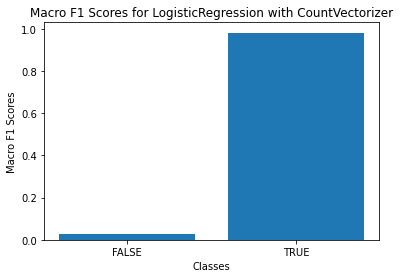

In [12]:
#Comparing Classifiers 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import random
#Define the training and validation sets:
X_train, X_val, y_train, y_val = train_test_split(rev_train_val, rec_train_val, test_size=0.2, random_state=12)

#Define the classifiers and their parameters:
dummy_classifiers = [    DummyClassifier(strategy="most_frequent"),    DummyClassifier(strategy="stratified")]
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)
svc = SVC(kernel='rbf')
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
results = {}

#Train the classifiers and evaluate them on the validation set:
for clf in dummy_classifiers + [logistic_regression, svc]:
    for vectorizer in [count_vectorizer, tfidf_vectorizer]:
        X_train_transformed = vectorizer.fit_transform(X_train)
        X_val_transformed = vectorizer.transform(X_val)
        clf.fit(X_train_transformed, y_train)
        y_pred = clf.predict(X_val_transformed)
        accuracy = accuracy_score(y_val, y_pred)
        precision_macro = precision_score(y_val, y_pred, average='macro',zero_division=0)
        recall_macro = recall_score(y_val, y_pred, average='macro')
        f1_macro = f1_score(y_val, y_pred, average='macro')
        results[(clf.__class__.__name__, vectorizer.__class__.__name__)] = (accuracy, precision_macro, recall_macro, f1_macro)

#Print the evaluation metrics:
print("Results on Validation Set:")
print("{:<25} {:<20} {:<10} {:<10} {:<10}".format('Classifier', 'Feature Representation', 'Accuracy', 'Precision', 'Recall', 'F1'))
for key, value in results.items():
    classifier, feature_representation = key
    accuracy, precision_macro, recall_macro, f1_macro = value
    print("{:<25} {:<20} {:.3f}      {:.3f}      {:.3f}     {:.3f}".format(classifier, feature_representation, accuracy, precision_macro, recall_macro, f1_macro))
best_clf = max(results, key=lambda x: results[x][3])
best_clf_name = best_clf[0]
best_vectorizer_name = best_clf[1]
X_train_transformed = vectorizer.fit_transform(rev_train_val)
X_val_transformed = vectorizer.transform(rev_val)
clf = eval(best_clf_name)()
clf.fit(X_train_transformed, rec_train_val)
y_pred = clf.predict(X_val_transformed)
f1_scores = f1_score(rec_val, y_pred, average=None)
classes = clf.classes_
plt.bar(classes, f1_scores)
plt.title(f"Macro F1 Scores for {best_clf_name} with {best_vectorizer_name}")
plt.xlabel("Classes")
plt.ylabel("Macro F1 Scores")
plt.show()


In [20]:
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000, C=10)

# Define the feature representations
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=1000)

# Evaluate the classifiers using cross-validation
for clf in [logistic_regression]:
    for vectorizer in  [tfidf_vectorizer]:
        X_train_transformed = vectorizer.fit_transform(rev_train)
        scores = cross_val_score(clf, X_train_transformed, rec_train, cv=5)
        print(f"{clf.__class__.__name__} with {vectorizer.__class__.__name__}: {scores.mean():.3f} +/- {scores.std():.3f}")


LogisticRegression with TfidfVectorizer: 0.958 +/- 0.002


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the pipeline with the vectorizer and classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=1000))
])

# Define the parameter grid to search over
param_grid = {
    'tfidf__sublinear_tf': [True, False],
    'tfidf__max_features': [None, 5000, 10000, 20000],
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(rev_val, rec_val)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: {:.3f}".format(grid_search.best_score_))




Best parameters:  {'clf__C': 1000, 'tfidf__max_features': None, 'tfidf__sublinear_tf': False}
Best score: 0.964


In [17]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(rev_train_val, rec_train_val, test_size=0.2, random_state=12)

# Vectorize the text
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Vectorize the text
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Train the classifier
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# Evaluate the classifier on the validation set
y_val_pred = clf.predict(X_val_tfidf)
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, average='macro',zero_division=0)
rec = recall_score(y_val, y_val_pred, average='macro')
f1 = f1_score(y_val, y_val_pred, average='macro')

print(f"Accuracy: {acc:.3f}")
print(f"Macro-averaged Precision: {prec:.3f}")
print(f"Macro-averaged Recall: {rec:.3f}")
print(f"Macro-averaged F1: {f1:.3f}")


Accuracy: 0.961
Macro-averaged Precision: 0.480
Macro-averaged Recall: 0.500
Macro-averaged F1: 0.490


In [55]:
'''# Define the ranges of values for each parameter
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
sublinear_tf_values = [True, False]
max_features_values = [None, 1000, 5000, 10000, 50000]
# Choose another parameter to tune
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

# Define a function to evaluate the classifier on the validation set with given parameters
def evaluate_classifier(c, sublinear_tf, max_features, kernel):
    vectorizer = TfidfVectorizer(sublinear_tf=sublinear_tf, max_features=max_features)
    X_train_transformed = vectorizer.fit_transform(X_train)
    X_val_transformed = vectorizer.transform(X_val)
    clf = SVC(kernel=kernel, C=c)
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_val_transformed)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    return f1_macro

# Loop through all combinations of parameter values and evaluate the classifier
best_f1_score = 0
for c in c_values:
    for sublinear_tf in sublinear_tf_values:
        for max_features in max_features_values:
            for kernel in kernel_values:
                f1_macro = evaluate_classifier(c, sublinear_tf, max_features, kernel)
                if f1_macro > best_f1_score:
                    best_f1_score = f1_macro
                    best_c = c
                    best_sublinear_tf = sublinear_tf
                    best_max_features = max_features
                    best_kernel = kernel

# Print the best parameter values and the corresponding f1 score on the validation set
print("Best parameters:")
print("C value:", best_c)
print("Sublinear TF:", best_sublinear_tf)
print("Max features:", best_max_features)
print("Kernel:", best_kernel)
print("Best F1 score on validation set:", best_f1_score)
'''


#Best parameters:
#C value: 10
#Sublinear TF: True
#Max features: 1000
#Kernel: linear
#Best F1 score on validation set: 0.7450214164172975

Best parameters:
C value: 10
Sublinear TF: True
Max features: 1000
Kernel: linear
Best F1 score on validation set: 0.7450214164172975


In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.7 MB/s eta 0:00:00


In [ ]:
from transformers import RobertaTokenizer, RobertaModel

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaModel

# Load the pre-trained model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Encode the text using the tokenizer
input_ids = []
for doc in data:
    encoded = tokenizer.encode(doc['Review'], add_special_tokens=True, truncation=True)
    input_ids.append(encoded)

# Pad the input sequences
max_len = max([len(seq) for seq in input_ids])
padded_input_ids = []
for seq in input_ids:
    padded_seq = seq + [0]*(max_len-len(seq))
    padded_input_ids.append(padded_seq)

# Convert the input sequences to tensors
input_ids = torch.tensor(padded_input_ids)

# Extract the first context vector for each document
outputs = model(input_ids)
context_vectors = outputs.last_hidden_state[:, 0, :].detach().numpy()


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
